## 고차 미분

In [1]:
import numpy as np
import weakref
import contextlib

In [2]:
class Config:
    """
    Flag 설정 class
    특징
        Flag의 역할을 수행하는 클래스이기 때문에 클래스의 인스턴스를 생성할 필요 없이 클래스 변수를 바로 사용함
        메모리 상에서는 이 함수의 클래스 변수가 선언될 때만 메모리가 할당되었다가 메모리 해제 시점이 올 경우 자동 해제되므로 전역변수로 설정하는 것에 비해서 메모리의 효율을 높일 수 있다.
    """
    enable_backprop = True


# 데코레이터를 활용해서 후처리를 자동으로 수행하기 위한 함수 생성
@contextlib.contextmanager
def using_config(name, value):
    old_value = getattr(Config, name) # getattr 옵션으로 기존 Config 클래스의 값을 저장
    setattr(Config, name, value) # setattr 옵션으로 Config 클래스 값 변경
    try:
        yield # 들여쓰기 내에 있는 본문을 실행하는 부분
    finally:
        setattr(Config, name, old_value) # setattr 옵션을 기존 옵션으로 다시 변경


# using_config 옵션 설정은 스위치 버튼이나 사용 시마다 쳐야하는 불편함을 제거하고자 추가적으로 함수 생성
def no_grad():
    return using_config('enable_backprop', False)

In [3]:
class Variable:
    """ Update Version (Level 3-1).
    Class Variable : np.array 값을 다루되 다른 멤버변수를 추가적인 특징으로 가져 다양한 정보를 모두 포함시키는 클래스.

    Parameter
    ---------
    data : np.array
        실제 연산에서 사용되는 값으로, 다양한 연산 및 정보 전달에도 사용
    grad : int, float
        역전파 수행 시, 현재 역전파 층에서의 gradient 값을 저장하여 다음 역전파에 전달하는 기능을 수행
    creator : callable function
        Variable 객체(인스턴스)를 연산하기 위한 함수가 무엇인지 저장하여 현재 객체는 creator에 들어온 함수값을 수행하기 위해 존재하는 것으로 판단하면 됨
    generation : Variable 객체가 어느 세대(generation)에 포함되어 있는지를 표현하기 위한 변수

    Functions
    ---------
    # 재귀 방식과 반복문 방식의 경우 메모리 할당 측면에서 반복문 방식이 유리하다.
    # 재귀 방식은 호출 시마다 메모리에 누적되나 반복문의 경우 pop을 활용해 메모리가 누적되지 않은 상태로 작업을 수월한다.
    __init__
        isinstance : 첫 번째 파라미터값의 타입과 두 번째 파라미터값의 동등 여부를 확인하는 함수
        retain_grad : gradient 값(y().grad)을 유지시킬지 설정하는 변수. default = False
        name : 차후 Variable에 이름을 달아주기 위해 설정
    cleargrad
        메모리 절약을 위해서 한 번 할당했던 변수를 또 다시 사용해야 할 경우 기존 메모리에 있던 Variable.grad 정보가 남아있기 때문에 할당을 해제해주어야 제대로 동작을 수행하게 된다.
    backward
        반복문을 이용한 역전파 코드
        while loop 내에서 zip 함수를 활용하여 x.grad에 중복되게 값이 들어갈 경우 기존 노드에 더해지도록 만들어 x + x = 2x 라는 식을 예로 들었을 때, gradient 값이 2로 정상 출력되게 하였음
        add_func
            역전파 시 함수가 pop되면서 새로운 값이 들어올 때, 같은 메모리를 참조하는 경우에 중복 방지를 위해서 추가된 함수
            이미지 결과를 보면 더 이해가 쉽기 때문에 아래 코드블럭 중 Check로 Markdown 표시를 한 곳에서 이미지를 확인하기를 추천!!!
        weakref
            순환 참조로 인해 생기는 메모리 누수 문제를 해결하기 위해 import된 weakref 객체에 대해 실제로 값을 출력할 때는 Variable처럼 weakref도 어떠한 기본 데이터타입을 감싸고 있는 형태이므로 기본 생성자를 통해 객체를 호출함과 동시에 output을 사용해 실제 결과값을 확인함
        >> Update
            self.grad. 즉 역전파 시작 시 기존에는 ndarray 인스턴스를 받았으나 고차 미분을 가능하게 하기 위해 ndarray 인스턴스가 아닌 Variable 인스턴스를 받도록 설정
    shape, ndim, size, dtype : numpy에 기본적으로 내장되어있는 메서드를 @property 데코레이터를 활용하여 바로 호출할 수 있도록 설정
    __len__ : data의 길이 반환
    __repr__ : print로 객체를 표현할 때 return할 값을 설정
    __mul__ : 다른 객체 또는 데이터타입과의 multiply 기능 지원
    """
    def __init__(self, data, name = None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError(f'{type(data)} is not supported.')

        self.data = data
        self.name = name
        self.grad = None
        self.creator = None
        self.generation = 0

    def cleargrad(self):
        self.grad = None

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    @property
    def shape(self):
        return self.data.shape

    @property
    def ndim(self):
        return self.data.ndim

    @property
    def size(self):
        return self.data.size

    @property
    def dtype(self):
        return self.data.dtype

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        if self.data is None:
            return "variable(None)"
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return f"variable({p}) from class's __repr__"

    def backward(self, retain_grad = False):
        if self.grad is None:
            self.grad = Variable(np.ones_like(self.data))

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key = lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)
        
            if not retain_grad:
                for y in f.outputs:
                    y().grad = None

In [4]:
# 타입 체크
def as_variable(obj):
    if isinstance(obj, Variable):
        return obj
    return Variable(obj)


# 타입 체크
def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x

In [5]:
class Function:
    """ Update Version (Level 3-1).
    Class Function : Variable 객체가 수행하는 함수들을 가지고 있는 클래스

    Parameter
    ---------
    input : Variable (Class instance)
    output : Variable (Class instance)
        input.data에 들어오는 ndarray 값을 함수 클래스를 통해 순전파된 결과인 y을 가지고 as_array 함수로 ndarray로 형변환하고 Variable의 __init__ 메서드로 값을 넣어 생성된 Variable 객체

    Functions
    ---------
    __call__
        위 클래스는 function 객체를 다루고 function 객체 내부에 input을 함수를 사용하듯이 값을 받음을 알 수 있음        
        inputs 파라미터를 리스트 데이터로 받아서 처리. 각각의 값은 Variable 객체로 구성되어 있음
        list comprehension을 사용하여 묶여진 객체들을 다시 인덱싱하여 결론을 도출함
        Level 2 버전의 Function 클래스와 큰 차이는 없으나 처음에 받는 인자를 가변인자를 받을 수 있도록 설정되어 있음
        generation 설정 : 이전까지의 Function 클래스의 경우 단일 노드들간의 연산이었으나, 지금부터는 여러 노드들에 대한 연산(ex. 더하기, 빼기 등)도 수행해야 하기 때문에 여러 노드들의 역전파를 효율적으로 수행하기 위해 함수 단계마다 세대(generation)를 설정하여 우선순위를 매긴 다음 역전파를 수행하도록 함
        return : outputs
        inputs 값을 가변인자로 받기 때문에 1개인 경우에 대한 예외처리가 필요하여 삼항 연산자를 활용해 조건에 따라 return되는 값을 다르게 하였음
        >> Update
            Config.enable_backprop : Config 라는 클래스를 생성하되 Flag 역할을 수행하도록 하여 해당 변수가 True값을 지니고 있을 경우 역전파 수행이 가능하도록 하였음. 이로 인해 생기는 효과는 역전파 수행이 필요 없을 경우 메모리를 절약할 수 있다는 장점이 있음
            weakref.ref : 현재 코드에서의 문제점은 메모리 누수가 발생할 수 밖에 없는 구조라는 것인데, 메모리 누수의 원인은 함수와 노드 사이의 연결이 서로가 서로를 참조하는 순환참조의 형태를 지니고 있기 때문임. 하여 weakref 모듈을 import하여 weakref가 참조하고 있는 변수의 메모리가 해제될 경우 이 변수도 정상적으로 메모리가 해제될 수 있도록 하였음
    forward, backward
        순전파 및 역전파 수행하는 클래스로써 기반클래스의 기본 포함 메서드. 파생 클래스에서 위 메서드들을 생성하지 않고 호출하게 되면 NotImplementedError를 raise하게 됨
        NotImplementedError : 파생 클래스에서 구현되지 않았음을 알리는 에러
    """
    def __call__(self, *inputs):
        inputs = [as_variable(x) for x in inputs]

        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]
        
        if Config.enable_backprop:
            self.generation = max([x.generation for x in inputs])
            for output in outputs:
                output.set_creator(self)
            self.inputs = inputs
            self.outputs = [weakref.ref(output) for output in outputs]
        
        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, x):
        raise NotImplementedError()

    def backward(self, gy):
        raise NotImplementedError()

In [6]:
class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y

    def backward(self, gy):
        return gy, gy

def add(x0, x1):
    return Add()(x0, x1)

In [7]:
class Mul(Function):
    def forward(self, x0, x1):
        y = x0 * x1
        return y

    def backward(self, gy):
        """ Update: self.inputs[0].data, self.inputs[1].data >> self.inputs """
        x0, x1 = self.inputs
        return x1 * gy, x0 * gy

def mul(x0, x1):
    x1 = as_array(x1)
    return Mul()(x0, x1)

In [8]:
class Sub(Function):
    def forward(self, x0, x1):
        y = x0 - x1
        return y

    def backward(self, gy):
        return gy, -gy


def sub(x0, x1):
    x1 = as_array(x1)
    return Sub()(x0, x1)

def rsub(x0, x1):
    x1 = as_array(x1)
    return Sub()(x1, x0)

In [9]:
class Div(Function):
    def forward(self, x0, x1):
        y = x0 / x1
        return y

    def backward(self, gy):
        x0, x1 = self.inputs
        gx0 = gy / x1
        gx1 = gy * (-x0 / x1 ** 2)
        return gx0, gx1


def div(x0, x1):
    x1 = as_array(x1)
    return Div()(x0, x1)

def rdiv(x0, x1):
    x1 = as_array(x1)
    return Div()(x1, x0)

In [10]:
class Neg(Function):
    def forward(self, x):
        return -x

    def backward(self, gy):
        return -gy


def neg(x):
    return Neg()(x)

In [11]:
class Pow(Function):
    def __init__(self, c):
        self.c = c

    def forward(self, x):
        y = x ** self.c
        return y

    def backward(self, gy):
        x = self.inputs[0]
        c = self.c

        gx = c * x ** (c - 1) * gy
        return gx


def pow(x, c):
    return Pow(c)(x)

In [12]:
class Variable:
    """ Update Version (Level 3-2).
    Class Variable : np.array 값을 다루되 다른 멤버변수를 추가적인 특징으로 가져 다양한 정보를 모두 포함시키는 클래스.

    Parameter
    ---------
    data : np.array
        실제 연산에서 사용되는 값으로, 다양한 연산 및 정보 전달에도 사용
    grad : int, float
        역전파 수행 시, 현재 역전파 층에서의 gradient 값을 저장하여 다음 역전파에 전달하는 기능을 수행
    creator : callable function
        Variable 객체(인스턴스)를 연산하기 위한 함수가 무엇인지 저장하여 현재 객체는 creator에 들어온 함수값을 수행하기 위해 존재하는 것으로 판단하면 됨
    generation : Variable 객체가 어느 세대(generation)에 포함되어 있는지를 표현하기 위한 변수

    Functions
    ---------
    # 재귀 방식과 반복문 방식의 경우 메모리 할당 측면에서 반복문 방식이 유리하다.
    # 재귀 방식은 호출 시마다 메모리에 누적되나 반복문의 경우 pop을 활용해 메모리가 누적되지 않은 상태로 작업을 수월한다.
    __init__
        isinstance : 첫 번째 파라미터값의 타입과 두 번째 파라미터값의 동등 여부를 확인하는 함수
        retain_grad : gradient 값(y().grad)을 유지시킬지 설정하는 변수. default = False
        name : 차후 Variable에 이름을 달아주기 위해 설정
    cleargrad
        메모리 절약을 위해서 한 번 할당했던 변수를 또 다시 사용해야 할 경우 기존 메모리에 있던 Variable.grad 정보가 남아있기 때문에 할당을 해제해주어야 제대로 동작을 수행하게 된다.
    backward
        반복문을 이용한 역전파 코드
        while loop 내에서 zip 함수를 활용하여 x.grad에 중복되게 값이 들어갈 경우 기존 노드에 더해지도록 만들어 x + x = 2x 라는 식을 예로 들었을 때, gradient 값이 2로 정상 출력되게 하였음
        add_func
            역전파 시 함수가 pop되면서 새로운 값이 들어올 때, 같은 메모리를 참조하는 경우에 중복 방지를 위해서 추가된 함수
            이미지 결과를 보면 더 이해가 쉽기 때문에 아래 코드블럭 중 Check로 Markdown 표시를 한 곳에서 이미지를 확인하기를 추천!!!
        weakref
            순환 참조로 인해 생기는 메모리 누수 문제를 해결하기 위해 import된 weakref 객체에 대해 실제로 값을 출력할 때는 Variable처럼 weakref도 어떠한 기본 데이터타입을 감싸고 있는 형태이므로 기본 생성자를 통해 객체를 호출함과 동시에 output을 사용해 실제 결과값을 확인함
        self.grad. 즉 역전파 시작 시 기존에는 ndarray 인스턴스를 받았으나 고차 미분을 가능하게 하기 위해 ndarray 인스턴스가 아닌 Variable 인스턴스를 받도록 설정
        >> Update
            create_graph 변수 추가: 역전파 1회 계산 후 역전파를 비활성 모드로 실행하게 만드는 파라미터
            with using_config(name, value): with 구문을 생성하여 역전파 설정을 통해 들여쓰기된 구문의 수행 여부를 판단
            쉽게 예를 들면, 가령 Mul 클래스의 backward 메서드는 gy * x1 계산을 수행하는데, 여기서 '* 연산자'는 오버로드 되어 있으므로 실제로는 Mul()(gy, x1) 코드가 호출되고, 이에 따라 Function의 __call__()이 호출되어 __call__() 메서드에서 Config.enable_backprop을 체크하여 역전파의 활성여부를 판단하게 됨. 만약 여기서 True값이 들어가게 되면 generation이 추가되고 input & output 값이 생성되므로 역전파를 한 번 더 수행하게 된다. 이런 식으로 연결고리가 계속 있을 경우에는 입력 변수 x.grad의 값을 볼 때까지 계속해서 역전파를 수행한다.
    shape, ndim, size, dtype : numpy에 기본적으로 내장되어있는 메서드를 @property 데코레이터를 활용하여 바로 호출할 수 있도록 설정
    __len__ : data의 길이 반환
    __repr__ : print로 객체를 표현할 때 return할 값을 설정
    __mul__ : 다른 객체 또는 데이터타입과의 multiply 기능 지원
    """
    def __init__(self, data, name = None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError(f'{type(data)} is not supported.')

        self.data = data
        self.name = name
        self.grad = None
        self.creator = None
        self.generation = 0

    def cleargrad(self):
        self.grad = None

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    @property
    def shape(self):
        return self.data.shape

    @property
    def ndim(self):
        return self.data.ndim

    @property
    def size(self):
        return self.data.size

    @property
    def dtype(self):
        return self.data.dtype

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        if self.data is None:
            return "variable(None)"
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return f"variable({p}) from class's __repr__"

    def backward(self, retain_grad = False, create_graph = False):
        if self.grad is None:
            self.grad = Variable(np.ones_like(self.data))

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key = lambda x: x.generation)
                # print("add_func: ", funcs)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]
            # print(f"f: {f}, {f.inputs[0].generation}")

            with using_config('enable_backprop', create_graph):
                gxs = f.backward(*gys)
                if not isinstance(gxs, tuple):
                    gxs = (gxs,)

                for x, gx in zip(f.inputs, gxs):
                    if x.grad is None:
                        x.grad = gx
                    else:
                        x.grad = x.grad + gx

                    if x.creator is not None:
                        add_func(x.creator)

            if not retain_grad:
                for y in f.outputs:
                    y().grad = None

In [13]:
Variable.__add__ = add
Variable.__radd__ = add
Variable.__neg__ = neg
Variable.__sub__ = sub
Variable.__rsub__ = rsub
Variable.__mul__ = mul
Variable.__rmul__ = mul
Variable.__truediv__ = div
Variable.__rtruediv__ = rdiv
Variable.__pow__ = pow

## 뉴턴 방식을 사용한 최적화(자동 계산)

In [14]:
# Jupyter Notebook에서는 .py 파일의 __file__ 변수를 지원하지 않기 때문에 sys 모듈을 import해서 경로를 추가해준 다음 사용해야 한다.
# import sys
# sys.path.append('..')
# from myPackage import Variable

In [15]:
def f(x):
    y = x ** 4 - 2 * x ** 2
    return y

In [16]:
x = Variable(np.array(2.))
y = f(x)
y.backward(create_graph=True)
print(x.grad)
print()

gx = x.grad
gx.backward()
print(x.grad)

variable(24.0) from class's __repr__

variable(68.0) from class's __repr__


In [17]:
x = Variable(np.array(2.))
y = f(x)
y.backward(create_graph=True)
print(x.grad)
print()

gx = x.grad
x.cleargrad()
gx.backward()
print(x.grad)

variable(24.0) from class's __repr__

variable(44.0) from class's __repr__


In [18]:
x = Variable(np.array(2.))
iters = 10

for i in range(iters):
    print(i, x)

    y = f(x)
    x.cleargrad()
    y.backward(create_graph=True)

    gx = x.grad
    x.cleargrad()
    gx.backward()
    gx2 = x.grad

    x.data -= gx.data / gx2.data

0 variable(2.0) from class's __repr__
1 variable(1.4545454545454546) from class's __repr__
2 variable(1.1510467893775467) from class's __repr__
3 variable(1.0253259289766978) from class's __repr__
4 variable(1.0009084519430513) from class's __repr__
5 variable(1.0000012353089454) from class's __repr__
6 variable(1.000000000002289) from class's __repr__
7 variable(1.0) from class's __repr__
8 variable(1.0) from class's __repr__
9 variable(1.0) from class's __repr__


## sin 함수 고차 미분

In [19]:
class Sin(Function):
    def forward(self, x):
        y = np.sin(x)
        return y

    def backward(self, gy):
        x, = self.inputs
        gx = gy * cos(x)
        return gx

def sin(x):
    return Sin()(x)

In [20]:
class Cos(Function):
    def forward(self, x):
        y = np.cos(x)
        return y

    def backward(self, gy):
        x, = self.inputs
        gx = gy * -sin(x)
        return gx
    
def cos(x):
    return Cos()(x)

In [21]:
x = Variable(np.array(1.))
y = sin(x)
y.backward(create_graph =  True)

for i in range(5):
    gx = x.grad
    x.cleargrad()
    gx.backward(create_graph=True)
    print(x.grad)

variable(-0.8414709848078965) from class's __repr__
variable(-0.5403023058681398) from class's __repr__
variable(0.8414709848078965) from class's __repr__
variable(0.5403023058681398) from class's __repr__
variable(-0.8414709848078965) from class's __repr__


In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

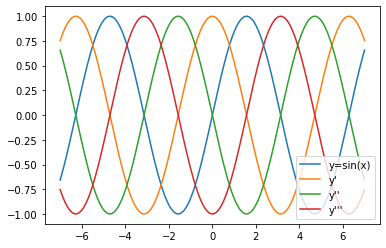

In [23]:
x = Variable(np.linspace(-7, 7, 200))
y = sin(x)
y.backward(create_graph=True)

logs = [y.data]

for i in range(3):
    logs.append(x.grad.data)
    gx = x.grad
    x.cleargrad()
    gx.backward(create_graph=True)

labels = ["y=sin(x)", "y'", "y''", "y'''"]
for i, v in enumerate(logs):
    plt.plot(x.data, logs[i], label=labels[i])
plt.legend(loc = 'lower right')
plt.show()

## 고차 미분 계산 그래프
#### 쌍곡탄젠트(하이퍼볼릭 탄젠트)
# $$ y = tanh(x) = \frac{e^{x}-e^{-x}}{e^{x}+e^{-x}} $$

In [24]:
class Tanh(Function):
    def forward(self, x):
        y = np.tanh(x)
        return y

    def backward(self, gy):
        y = self.outputs[0]()
        gx = gy * (1 - y * y)
        return gx

def tanh(x):
    return Tanh()(x)

In [25]:
x = Variable(np.array(1.))
y = tanh(x)
x.name = 'x'
y.name = 'y'
y.backward(create_graph=True)
print(x.grad)
iters = 0

for i in range(iters):
    gx = x.grad
    x.cleargrad()
    gx.backward(create_graph=True)
    print(x.grad)

variable(0.41997434161402614) from class's __repr__
